#### Batch Script to Translate to Python

Input = a mol2 file \
Output = A csv of the predicted spectrum

In [132]:
#Moving any imports to front as I go
import numpy as np
from numpy import real
import glob
import math
import matplotlib.pyplot as plt
alpha=1.292              #electrostatic
beta=-3.26934291633      #covalent

## HUCKEL Molecular Orbital (HMO) Calculations

### CHEM344  Physical Chemistry
#### Department of Chemistry
#### Illinois Institute of Technology

#### Original Bash Code By Jingbai Li
#### Translated to Python by Joseph DePaolo-Boisvert
#### HUCKELMO Version 2.0  Aug 30th 2017
#### Nov 1st, 2022

In [188]:
# #only print real part of eigenvalues   Feb 28th 2018 Jingbai Li
# #V2-UI revised, interfaced with GView Aug 25th 2017 Jingbai Li
# #Huckel_structures_calculator Feb 22th 2016 Jingbai Li 

# #!/bin/sh
# #Variables

# #home=~/Desktop/Huckel_Structures
# home=./
# cd $home


mol2files = glob.glob('structures/*.mol2')

if len(mol2files) == 0:
    raise Exception('No Input Files Found')

def run_mol2_file(mol2_fn):
    # #Initial Parameters
    alpha=1.292              #electrostatic
    beta=-3.26934291633      #covalent
    ele_num=0                #electrons
    orb=0                    #orbitals
    # alpha beta types: 1:C=C-C 2:C-N-C 3:C=N-C
    # diagonal-alpha, alpha’=alpha + h * beta, C=C:0 C=N:2 C-N:1.5
    # connected-beta, beta’=k*beta, C=C:1 C=N:1 C-N:0.8
    with open(mol2_fn, 'r') as f:
        lines = [line[:-1] if line.endswith('\n') else line for line in f.readlines()]
    
    atomsec = lines[lines.index("@<TRIPOS>ATOM") + 1:lines.index("@<TRIPOS>BOND")]
    atomsec = [[element for element in atom.split(' ') if element != ''] for atom in atomsec]
    num_atoms = len(lines)
    
    bondsec = lines[lines.index("@<TRIPOS>BOND") + 1 :]
    if bondsec[-1] == '':
        bondsec.pop(-1)
    
    bonds = []
    for bond in bondsec:
        bond = bond.split(' ')
        if bond[-1] == '1':
            bond[-1] = 'S'
        elif bond[-1] == '2':
            bond[-1] = 'D'
        else:
            bond[-1] = 'N'
        bonds.append(bond)
    bondsec = bonds
    numbonds = len(bondsec)
    #print(atomsec)
    #print(bondsec)
    
    # #detect atom type, matrix dimension, diagonal element
    typ = {}
    dim = len(atomsec)
    matrix = np.zeros((dim, dim))
    for atom in atomsec:
        atom_type = atom[-1]
        atom_ind = int(atom[0]) - 1
        if atom_type == 'C':
            valence = 0 #the number of times it is listed in a bond
            for bond in bondsec:
                if atom[0] in bond[1:3]:
                    valence += 1
            if valence < 4:
                typ[atom[0]] = 1
                h = 0.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 0
            
        elif atom_type == 'N':
            pyridine = False
            for bond in bondsec:
                if atom[0] in bond and 'D' in bond:
                    pyridine = True
            if pyridine:
                typ[atom[0]] = 3
                h = 2.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 2
                h = 1.500
                ele_num += 2 ####
                orb += 1
        
        else:
            typ[atom[0]] = 0
            h = -1 * alpha / beta
        
        matrix[atom_ind, atom_ind] = alpha + h * beta
    #print(typ)
    #print(matrix)
    
    # #detect bond type, none-zero matrix element
    for bond in bonds:
        b1 = bond[1]
        b2 = bond[2]
        if typ[b1] == 0 or typ[b2] == 0:
            k = 0.000
        elif typ[b1] == 2 or typ[b2] == 2:
            k = 0.800
        else:
            k = 1.000
        b1_ind, b2_ind = int(b1) - 1, int(b2) - 1
        matrix[b1_ind, b2_ind] = k * beta
        matrix[b2_ind, b1_ind] = k * beta
    
    b = np.linalg.eigvals(matrix)
    energies = [element for element in np.sort(real(b)) if element != 0 and element != alpha]
    
    print(f'Num_Electrons = {ele_num}')
    
    base = ele_num // 2
    
    print()
    print('Orbital Energies (au)')
    
    for i in range(len(energies)):
        s = f'{i+1}      {energies[i]:.4f}'
        if i+1  == base: # base is 1 indexed and i is zero
            s = f'{i+1} HOMO {energies[i]:.4f}'
            homo_ind = i
        elif i+1 == base + 1:
            s = f'{i+1} LUMO {energies[i]:.4f}'
            lumo_ind = i
        print(s)
    
    gap_energy = energies[lumo_ind] - energies[homo_ind]
    print()
    print(f'HOMO-LUMO Gap = {gap_energy:.5f} (au)')
    print()
    x = np.arange(100,1601)
    y = lambda x, gap_energy : math.sqrt(2/math.pi)/70*math.e**(-2*((x-(2.998*10**8)*10**9/((1.60217656*10**(-19))/(6.626*10**(-34)))/(gap_energy))/70)**2)
    
    plt.clf()
    plt.title('Prdeicted Spectrum')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    _ = plt.plot(x, y(x, gap_energy))
    plt.show()

In [189]:
(-1*alpha / beta)

0.39518644359593036

Num_Electrons = 25

Orbital Energies (au)
1      -6.8853
2      -6.8290
3      -5.0627
4      -4.7473
5      -4.5551
6      -4.1499
7      -2.5504
8      -1.9773
9      -1.9773
10      -1.6171
11      -1.3920
12 HOMO 0.2545
13 LUMO 2.0635
14      3.4715
15      4.5613
16      4.5613
17      4.7907
18      4.8978
19      5.5169
20      6.7738
21      7.2519
22      8.6696
23      8.8385

HOMO-LUMO Gap = 1.80901 (au)



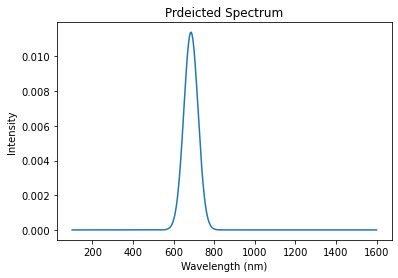

In [192]:
out = run_mol2_file('structures/11DIETHYL44CARBOCYANINE.mol2')

In [95]:
import numpy as np
from numpy import loadtxt
from numpy import real
#a = loadtxt('secular_determinant.txt')
b = np.linalg.eigvals(out)
b = real(b)
c = np.sort(b)
s = ''
#f = open('eigenvalues.txt','w')
for line in c:
    if line != 0 and line != alpha: # get rid of inappropriate eigenvals
        print(line)

-5.24668583266
-1.9773429163300007
-1.9773429163299996
4.561342916329999
4.561342916330001
7.830685832660006
